In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from hottbox.core import Tensor, TensorTKD
from hottbox.algorithms.decomposition import HOSVD, HOOI
from hottbox.utils.generation import residual_tensor
from coursework.data import get_image, plot_tensors

In [4]:
np.random.seed(0)

[Return to Table of Contents](./0_Table_of_contents.ipynb)

# Tucker Decomposition

<img src="./imgs/TensorTKD.png" alt="Drawing" style="width: 500px;"/>

In previous [assignment](./2_Efficient_representation_of_multidimensional_arrays.ipynb), you have been provided materials which cover efficient representations of mutlidimensional arrays of data, such as the Tucker form. In this module, you will take a closer look at it and the assiciated computational methods.


Any tensor of arbitrarily large order can be decomposed in the Tucker form. As illustrated above, a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I \times J \times K}$ can be represented as a dense core tensor $\mathbf{\underline{G}}$ and a set of factor matrices $\mathbf{A} \in \mathbb{R}^{I \times Q}, \mathbf{B} \in \mathbb{R}^{J \times R}$ and $\mathbf{C} \in
\mathbb{R}^{K \times P}$

$$
\mathbf{\underline{X}} = \mathbf{\underline{G}} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C} = \Big[    \mathbf{\underline{G}} ;  \mathbf{A},  \mathbf{B}, \mathbf{C}      \Big]
$$


On practice, there exist several computational methods to accomplish this all of which are combined into a Tucker Decomposition framework. The two most commonly used algorithms are:
1. Higher Order Singular Value Decomposition ([HOSVD](#Higher-Order-Singular-Value-Decomposition-(HOSVD)))
1. Higher Order Orthogonal Iteration ([HOOI](#Higher-Order-Orthogonal-Iteration-(HOOI)))


# Higher Order Singular Value Decomposition (HOSVD)

The HOSVD is a special case of the Tucker decomposition, in which all the factor matrices are constrained to be orthogonal. They are computed as truncated version of the left singular matrices of all possible mode-$n$ unfoldings of tensor $\mathbf{\underline{X}}$:

$$
\begin{aligned}
\mathbf{X}_{(1)} &= \mathbf{U}_1  \mathbf{\Sigma}_1 \mathbf{V}_1^T \quad \rightarrow \quad \mathbf{A} = \mathbf{U}_1[1:R_1]\\
\mathbf{X}_{(2)} &= \mathbf{U}_2  \mathbf{\Sigma}_2 \mathbf{V}_2^T \quad \rightarrow \quad \mathbf{B} = \mathbf{U}_2[1:R_2] \\
\mathbf{X}_{(3)} &= \mathbf{U}_3  \mathbf{\Sigma}_3 \mathbf{V}_3^T \quad \rightarrow \quad \mathbf{C} = \mathbf{U}_3[1:R_3] \\
\end{aligned}
$$

After factor matrices are obtained, the core tensor $\mathbf{\underline{G}}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^T \times_2 \mathbf{B}^T \times_3 \mathbf{C}^T        
$$


# Higher Order Orthogonal Iteration (HOOI)

HOOI algorithm is another special case of the Tuker decomposition. Like HOSVD, it decomposes a tensor into a dense core tensor and orthogonal factor matrices. The difference between the two lies in the fact that in HOOI the factor matrices are optimized iteratively using an Alternating Least Squares (ALS) approach. In other words, the tucker representation $[ \mathbf{\underline{G}};\mathbf{A}^{(1)}, \mathbf{A}^{(2)}, \cdots,\mathbf{A}^{(N)} ]$ of the given tensor $\mathbf{\underline{X}}$ is obtained through the HOOI as follows

$$
\begin{aligned}
&\mathbf{\underline{Y}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T} \times_2 \cdots \times_{n-1} \mathbf{A}^{(n-1)T} \times_{n+1} \mathbf{A}^{(n+1)} \times \cdots \times_N \mathbf{A}^{(N)} \\
&\mathbf{A}^{(n)} \leftarrow R_n \text{ leftmost singular vectors of } \mathbf{Y}_{(n)}
\end{aligned}
$$

The above is repeated until convergence, then the core tensor $\mathbf{\underline{G}} \in \mathbb{R}^{R_1 \times R_2 \times \cdots \times R_N}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T}  \times_2 \mathbf{A}^{(2)T} \times_3 \cdots  \times_N \mathbf{A}^{(N)T}
$$

# Multi-linear rank

The **multi-linear rank** of a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ is the $N$-tuple $(R_1, \dots, R_N)$ where each $R_n$ is the rank of the subspace spanned by mode-$n$ fibers, i.e. $R_n = \text{rank} \big( \mathbf{X}_{(n)} \big)$. Thus, for our order-$3$ tensor the multi-linear rank is $(R_1, R_2, R_3)$. Multi-linear rank provides flexibility in compression and approximation of the original tensor.

> **NOTE:** For a tensor of order $N$ the values $R_1, R_2, \dots , R_N$ are not necessarily the same, whereas, for matrices (tensors of order 2) the equality $R_1 = R_2$ always holds, where $R_1$ and $R_2$ are the matrix column rank and row rank respectively.



# Performing tensor decomposition

In [5]:
# Create tensor
I, J, K = 5, 6, 7
array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(float)
tensor = Tensor(array_3d)

# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 5, 6)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(4, 5, 6).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (5, 6, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (6, 5)
Mode-2 factor matrix is of shape (7, 6)

	Core tensor
This tensor is of order 3 and consists of 120 elements.
Sizes and names of its modes are (4, 5, 6) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Evaluation and reconstruction

Tucker representation of an original tensor is almost always an approximation, regardless of which algorithm has been employed for performing decomposition. Thus, relative error of approximation is commonly used in order to evaluate performance of computational methods, i.e. the ratio between a Frobenious norms of residual and original tensors.

In [6]:
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Relative error of approximation = 0.21320264561618077


## **Assigment 1**

1. Create a tensor of order 4 with sizes of each mode being defined by prime numbers and  obtain a Tucker representation using HOOI algorithm with multi-linear (4, 10, 6, 2). Then calculation ratio between the number of elements in the original tensor and its Tucker form.

1. For a tensor that consists of 1331 elements, which multi-linear rank guarantees a perfect reconstruction from its Tucker form and why. Is such choice reasonable for practical applications?


### Solution: Part 1

In [7]:
# Create a tensor
I, J, K, Q = 2, 3, 5, 7
array_4d = np.random.rand(I * J * K * Q).reshape((I, J, K, Q)).astype(float)
tensor = Tensor(array_4d)

In [8]:
# Perform decomposition
algorithm = HOSVD()
ml_rank = (4, 10, 6, 2)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(2, 3, 5, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2', 'mode-3']
With corresponding latent components described by (2, 3, 5, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (2, 2)
Mode-1 factor matrix is of shape (3, 3)
Mode-2 factor matrix is of shape (5, 5)
Mode-3 factor matrix is of shape (7, 2)

	Core tensor
This tensor is of order 4 and consists of 60 elements.
Sizes and names of its modes are (2, 3, 5, 2) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.


In [9]:
# Print ratio
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Relative error of approximation = 0.38871898964218055


### Solution: Part 2

**By expressing 1331 with its prime factors, a result os 11^3 is obtained. Since perfect decomposition is achieved when the multi-linear rank is equal to the size of the core tensor, a value of (11, 11, 11) can be used to avoide approximations during the decomposition, thus allowing perfect reconstruction. In practical applications, however, it is not always necessary to preserve 100% of the information in the data, since that would imply a higher computational burden. A trade-off between complexity and accuracy should thus be determined for each specific application, and the size of the core tensor should be chosen accordingly.**


# Application: Image compression 

Color images can be naturally represented as a tensor of order three with the shape `(height x width x channels)` where channels are, for example, Red, Blue and Green (RGB)

<img src="./imgs/image_to_base_colors.png" alt="Drawing" style="width: 500px;"/>

By keeping its original structure, allows to apply methods from multi-linear analysis. For instance, we can employ algorithms for Tucker decompositions in order to commress oringinal informaiton by varying values of desired multi-linear rank.

```python
# Get data in form of a Tensor
car = get_image(item="car", view="top")
tensor = Tensor(car)

# Initialise algorithm and preform decomposition
algorithm = HOSVD()
tensor_tkd = algorithm.decompose(tensor, rank=(25, 25, 3))

# Evaluate result
tensor_res = residual_tensor(tensor, tensor_tkd)
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))
```

When can also visually inspect image obtained by reconstructing the Tucker representation
```python
# Reconstruction
tensor_rec = tensor_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor, tensor_rec)
```

<img src="./imgs/car_orig_vs_reconstructed_25_25_3.png" alt="Drawing" style="width: 500px;"/>

## **Assigment 2**
For this assignment you are provided with function `get_image()` which requires two parameters: `item` and `view`. The valid values for former are **car** and **apple**, while the latter takes only **side** and **top**. 

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the car and apple. Analyse results by visually inspecting their reconstructions.

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the apple taken from the top and from the side. Analyse results by visually inspecting their reconstructions.

1. What would happen to the reconstruction if the value of multi-linear rank corresponding to the channel mode is decreased to 1.


### Solution: Part 1

In [10]:
# Create tensors from images
# Get data in form of a Tensor
car = get_image(item="car", view="top")
apple = get_image(item="apple", view="top")
tensor_car = Tensor(car)
tensor_apple = Tensor(apple)

print(tensor_car)
print('\n')
print(tensor_apple)

This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.


This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.


In [11]:
# Perform decomposition
algorithm = HOOI()
tensor_tkd_car = algorithm.decompose(tensor_car, rank=(50, 50, 2))
tensor_tkd_apple = algorithm.decompose(tensor_apple, rank=(50, 50, 2))
print('Decomposed car tensor: ', tensor_tkd_car)
print('Decomposed apple tensor: ', tensor_tkd_apple)

Decomposed car tensor:  Tucker representation of a tensor with multi-linear rank=(50, 50, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (128, 128, 3) features respectively.
Decomposed apple tensor:  Tucker representation of a tensor with multi-linear rank=(50, 50, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (128, 128, 3) features respectively.


Relative error of approximation for the car image = 0.04937809664838521
Relative error of approximation for the apple image = 0.036872700375586


Reconstructed car tensor:  This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.
Reconstructed apple tensor:  This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.




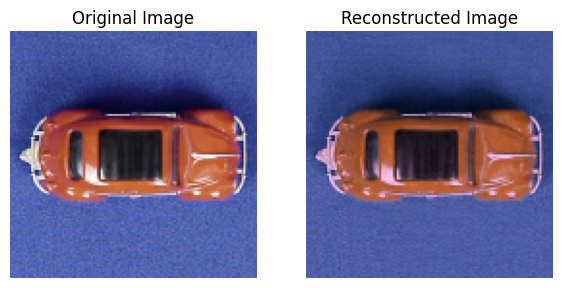

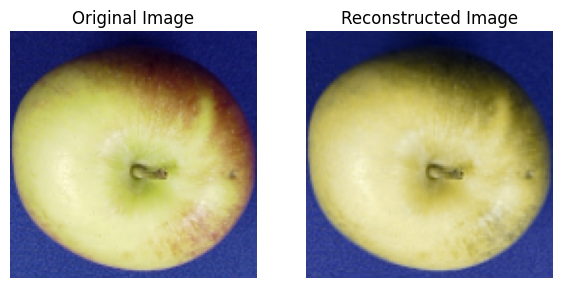

In [12]:
# Evaluate results
tensor_res_car = residual_tensor(tensor_car, tensor_tkd_car)
rel_error_car = tensor_res_car.frob_norm / tensor_car.frob_norm
print("Relative error of approximation for the car image = {}".format(rel_error_car))
tensor_res_apple = residual_tensor(tensor_apple, tensor_tkd_apple)
rel_error_apple = tensor_res_apple.frob_norm / tensor_apple.frob_norm
print("Relative error of approximation for the apple image = {}".format(rel_error_apple))

print('\n')
# Reconstruction
tensor_rec_car = tensor_tkd_car.reconstruct()
tensor_rec_apple = tensor_tkd_apple.reconstruct()
print('Reconstructed car tensor: ', tensor_rec_car)
print('Reconstructed apple tensor: ', tensor_rec_apple)

print('\n')
# Plot original and reconstructed images side by side
plot_tensors(tensor_car, tensor_rec_car)
plot_tensors(tensor_apple, tensor_rec_apple)

**By observing the reconstructed images (using HOOI algorithm and multi-linear rank of (50, 50, 2)) and comparing them to the original ones, two aspects are clearly noticeable: resolution and colours. First of all, the resulting reconstructed images appear to be slightly blurred. This is especially clear when looking at the blue background and shadows, and is due to the first two elements of the chosen multi-linear rank: (50, 50) . The second aspect is the absence of one of the colour channels (green for the car picture and red for the apple one), again due to the chosen multi-linear rank (third element, which is 2 instead of 3). Despite the considerably lower rank, however, the resulting reconstructed images are not too different from the original ones, as also highlighted by the reconstruction error, which is only around 4%-5% for both images.**


### Solution: Part 2

In [16]:
# Create tensors from images
apple_side = get_image(item="apple", view="side")
apple_top = get_image(item="apple", view="top")
tensor_apple_side = Tensor(apple_side)
tensor_apple_top = Tensor(apple_top)

print(tensor_apple_side)
print('\n')
print(tensor_apple_top)

This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.


This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.


In [20]:
# Perform decomposition
algorithm = HOOI()
tensor_tkd_apple_side = algorithm.decompose(tensor_apple_side, rank=(50, 50, 2))
tensor_tkd_apple_top = algorithm.decompose(tensor_apple_top, rank=(50, 50, 2))
print('Decomposed car tensor: ', tensor_tkd_apple_side)
print('Decomposed apple tensor: ', tensor_tkd_apple_top)

Decomposed car tensor:  Tucker representation of a tensor with multi-linear rank=(50, 50, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (128, 128, 3) features respectively.
Decomposed apple tensor:  Tucker representation of a tensor with multi-linear rank=(50, 50, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (128, 128, 3) features respectively.


Relative error of approximation for the car image = 0.04937809664838521
Relative error of approximation for the apple image = 0.04213830076953536


Reconstructed car tensor:  This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.
Reconstructed apple tensor:  This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.




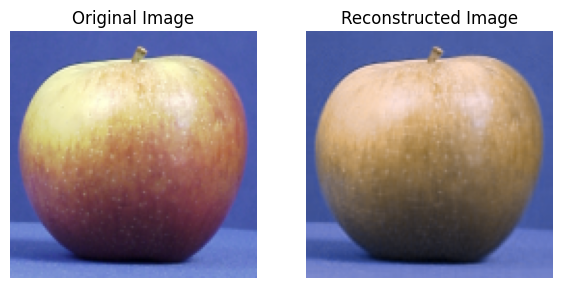

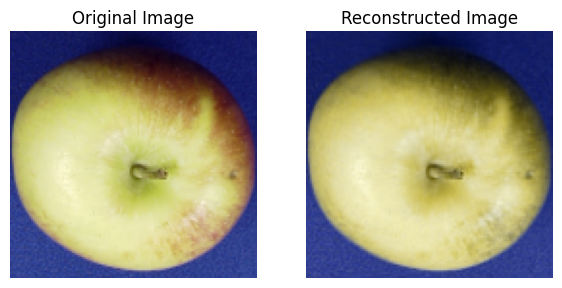

In [21]:
# Evaluate results
tensor_res_apple_side = residual_tensor(tensor_apple_side, tensor_tkd_apple_side)
rel_error_apple_side = tensor_res_apple_side.frob_norm / tensor_apple_side.frob_norm
print("Relative error of approximation for the car image = {}".format(rel_error_car))
tensor_res_apple_top = residual_tensor(tensor_apple_top, tensor_tkd_apple_top)
rel_error_apple_top = tensor_res_apple_top.frob_norm / tensor_apple_top.frob_norm
print("Relative error of approximation for the apple image = {}".format(rel_error_apple_top))

print('\n')
# Reconstruction
tensor_rec_apple_side = tensor_tkd_apple_side.reconstruct()
tensor_rec_apple_top = tensor_tkd_apple_top.reconstruct()
print('Reconstructed car tensor: ', tensor_rec_apple_side)
print('Reconstructed apple tensor: ', tensor_rec_apple_top)

print('\n')
# Plot original and reconstructed images side by side
plot_tensors(tensor_apple_side, tensor_rec_apple_side)
plot_tensors(tensor_apple_top, tensor_rec_apple_top)

**By looking at the resulting pictures of the same object from two different sides, some key differences are noticed. Due to the more extended presence of 'red' in the side picture, and because the reconstruction only uses a multi-linear-rank value equal to 2 (the two most significant channels), the resulting image for the side view appears worse overall. This is confirmed by the approximation error, which is much higher for the first picture. On the other hand, since the second picture has a much lower presence of red, removing such a channel has a much smaller effect on the reconstruction error, thus yielding a picture which more closely resembles the original one.**


### Solution: Part 3

**If the reconstruction used only a multi-linear rank equal to 1, the outcome would be similar to a grey-scale representation of the picture, with the difference that only the most significant channel between red, green and blue would be used instead (e.g. a picture coloured only with different shadows of the most relevant colour).**
